In [ ]:
"""""
import pandas as pd, numpy as np
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.base import BaseEstimator, TransformerMixin
from packaging import version
from scipy import sparse
import joblib, pathlib, sklearn

df = pd.read_excel("./1507.xlsx")
# -----------------------------------------------------------
# 1) Kullanılacak sütunlar – metin tabanlı olanlar çıkarıldı
# -----------------------------------------------------------
USE_COLS = [
    "date",
    "duration_ms", 
    "explicit", 
    "available_markets",
    "af_danceability", "af_energy", "af_key", "af_loudness",
    "af_mode", "af_speechiness", "af_acousticness", "af_instrumentalness",
    "af_liveness", "af_valence", "af_tempo", "af_time_signature",
    "artist_followers"
]
TARGET = "popularity"

df = df[USE_COLS + [TARGET]].copy()

# -----------------------------------------------------------
# 2) Sütun grupları
# -----------------------------------------------------------
numeric_cols = [
    "duration_ms", "artist_followers",
    "af_danceability","af_energy","af_loudness",
    "af_speechiness","af_acousticness","af_instrumentalness",
    "af_liveness","af_valence","af_tempo"
]

low_card_cat = [
    "explicit", "af_key", "af_mode", "af_time_signature"
]

list_cols = ["available_markets"]

# -----------------------------------------------------------
# 3) Dönüştürücü: available_markets → uzunluk
# -----------------------------------------------------------
class ListLength(BaseEstimator, TransformerMixin):
    def __init__(self, col="available_markets"): self.col = col
    def fit(self, X, y=None): return self
    def transform(self, X):
        out = X.copy()
        out[self.col] = out[self.col].fillna("[]")                 \
                        .apply(lambda s: len(eval(s)) if isinstance(s,str) else len(s))
        return out

# -----------------------------------------------------------
# 4) Tarih → datetime  +  veri ayrımı
# -----------------------------------------------------------
df["date"] = pd.to_datetime(df["date"], errors="coerce")

train_idx = df["date"].dt.year.isin([2017, 2018])
val_idx   = df["date"].dt.year == 2019
test_idx  = df["date"].dt.year == 2020

X_train_raw = df.loc[train_idx, USE_COLS]
y_train     = df.loc[train_idx, TARGET].values
X_val_raw   = df.loc[val_idx,   USE_COLS]
y_val       = df.loc[val_idx,   TARGET].values
X_test_raw  = df.loc[test_idx,  USE_COLS]
y_test      = df.loc[test_idx,  TARGET].values

# -----------------------------------------------------------
# 5) Pipeline ve Transformer tanımları
# -----------------------------------------------------------
if version.parse(sklearn.__version__) >= version.parse("1.4"):
    ohe = OneHotEncoder(handle_unknown="ignore", sparse_output=False)
else:
    ohe = OneHotEncoder(handle_unknown="ignore", sparse=False)

numeric_pipe = Pipeline([
    ("imp", SimpleImputer(strategy="median")),
    ("sc",  StandardScaler())
])
categorical_pipe = Pipeline([
    ("imp", SimpleImputer(strategy="most_frequent")),
    ("ohe", ohe)
])
listlen_pipe = Pipeline([
    ("len", ListLength()),
    ("imp", SimpleImputer(strategy="median")),
    ("sc",  StandardScaler())
])

preproc = ColumnTransformer([
    ("num",     numeric_pipe,   numeric_cols),
    ("cat",     categorical_pipe, low_card_cat),
    ("markets", listlen_pipe,   ["available_markets"])
], sparse_threshold=0.0)  # force dense

# -----------------------------------------------------------
# 6) Fit/transform işlemleri
# -----------------------------------------------------------
X_train = preproc.fit_transform(X_train_raw)
X_val   = preproc.transform(X_val_raw)
X_test  = preproc.transform(X_test_raw)

if sparse.issparse(X_train):
    X_train, X_val, X_test = map(np.asarray, (X_train, X_val, X_test))

# -----------------------------------------------------------
# 7) Kaydet
# -----------------------------------------------------------
pathlib.Path("prepared_data2").mkdir(exist_ok=True)
np.savez_compressed("prepared_data2/sets_notext.npz",
                    X_train=X_train, y_train=y_train,
                    X_val=X_val,     y_val=y_val,
                    X_test=X_test,   y_test=y_test)
joblib.dump(preproc, "prepared_data2/preprocessor_notext.joblib")
print("✅ prepared_data2/sets_notext.npz  +  preprocessor_notext.joblib written")
"""""


✅ prepared_data2/sets_notext.npz  +  preprocessor_notext.joblib written


In [10]:
# ------------  MODEL CELL  -----------------------------------------------
import numpy as np, joblib
from lightgbm import LGBMRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# 1) load prepared data
data = np.load("prepared_data2/sets_notext.npz")
X_train, y_train = data["X_train"], data["y_train"]
X_val,   y_val   = data["X_val"],   data["y_val"]
X_test,  y_test  = data["X_test"],  data["y_test"]

# 2) model
lgbm = LGBMRegressor(n_estimators=50, learning_rate=0.05,
                     num_leaves=24, subsample=0.9,
                     colsample_bytree=0.8, random_state=42)
lgbm.fit(X_train, y_train)

# 3) metrics helper
rmse = lambda yt, yp: np.sqrt(mean_squared_error(yt, yp))

# 4) evaluate
val_pred  = lgbm.predict(X_val)
test_pred = lgbm.predict(X_test)

print("\n=== Validation 2019 ===")
print(f"MAE : {mean_absolute_error(y_val, val_pred):.2f}")
print(f"RMSE: {rmse(y_val, val_pred):.2f}")
print(f"R²  : {r2_score(y_val, val_pred):.3f}")

print("\n=== Test 2020 ===")
print(f"MAE : {mean_absolute_error(y_test, test_pred):.2f}")
print(f"RMSE: {rmse(y_test, test_pred):.2f}")
print(f"R²  : {r2_score(y_test, test_pred):.3f}")
# -------------------------------------------------------------------------


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001098 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2651
[LightGBM] [Info] Number of data points in the train set: 4299, number of used features: 30
[LightGBM] [Info] Start training from score 49.263550

=== Validation 2019 ===
MAE : 10.47
RMSE: 13.09
R²  : 0.341

=== Test 2020 ===
MAE : 12.07
RMSE: 15.20
R²  : 0.265


c:\Users\4444e\anaconda3\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
c:\Users\4444e\anaconda3\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


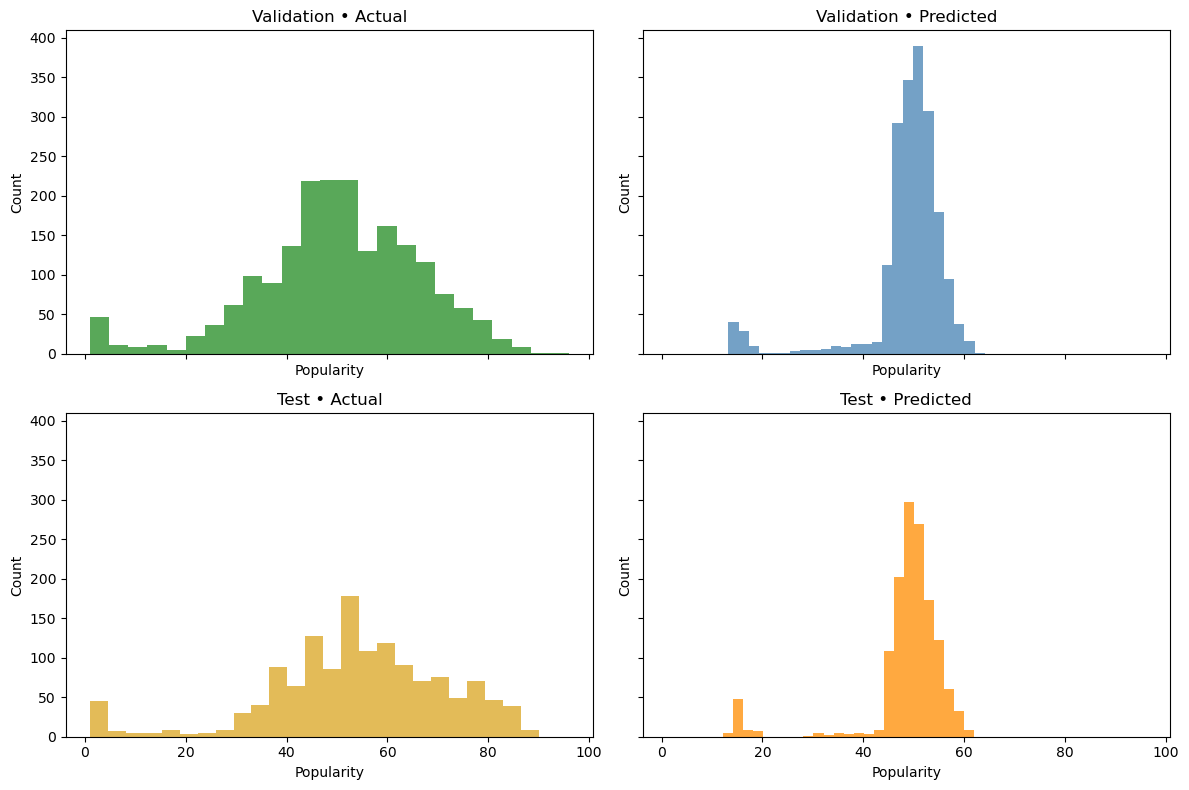


Summary statistics
Val Actual         | mean  50.00  std  16.12  min   1.00  max  96.00
Val Predicted      | mean  48.73  std   8.24  min  13.22  max  64.10
Test Actual        | mean  53.96  std  17.73  min   1.00  max  90.00
Test Predicted     | mean  48.54  std   8.58  min  12.17  max  62.01


In [ ]:
import numpy as np
import matplotlib.pyplot as plt



# ───── actual targets (already defined) ───────────────────────
val_true  = y_val.values if hasattr(y_val, "values") else y_val
test_true = y_test.values if hasattr(y_test, "values") else y_test

# ───── plot 2×2 histograms ────────────────────────────────────
fig, axes = plt.subplots(2, 2, figsize=(12, 8), sharex=True, sharey=True)
bins = 25

axes[0, 0].hist(val_true,  bins=bins, alpha=0.75, color="forestgreen")
axes[0, 0].set_title("Validation • Actual")

axes[0, 1].hist(val_pred, bins=bins, alpha=0.75, color="steelblue")
axes[0, 1].set_title("Validation • Predicted")

axes[1, 0].hist(test_true,  bins=bins, alpha=0.75, color="goldenrod")
axes[1, 0].set_title("Test • Actual")

axes[1, 1].hist(test_pred, bins=bins, alpha=0.75, color="darkorange")
axes[1, 1].set_title("Test • Predicted")

for ax in axes.flat:
    ax.set_xlabel("Popularity"); ax.set_ylabel("Count")

plt.tight_layout()
plt.show()

# ───── descriptive statistics ─────────────────────────────────
def describe(arr, label):
    print(f"{label:18s} | mean {np.mean(arr):6.2f}  std {np.std(arr):6.2f}  "
          f"min {np.min(arr):6.2f}  max {np.max(arr):6.2f}")

print("\nSummary statistics")
describe(val_true,  "Val Actual")
describe(val_pred,  "Val Predicted")
describe(test_true, "Test Actual")
describe(test_pred, "Test Predicted")


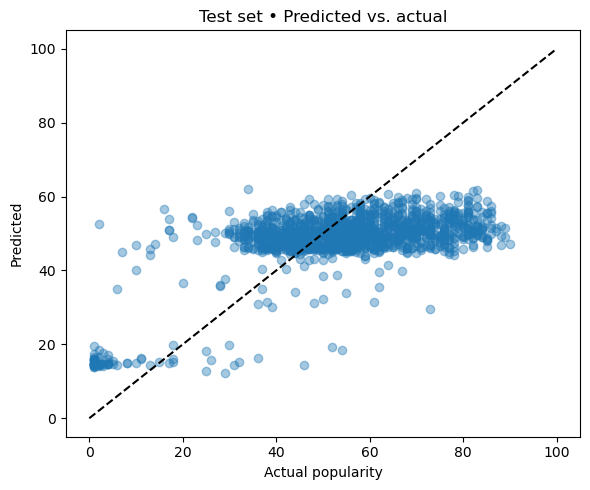

In [12]:

plt.figure(figsize=(6,5))
plt.scatter(test_true, test_pred, alpha=0.4)
plt.plot([0,100], [0,100], "k--")               # 45° reference
plt.xlabel("Actual popularity"); plt.ylabel("Predicted")
plt.title("Test set • Predicted vs. actual")
plt.tight_layout()
plt.show()


In [ ]:
# ─────────────────────────────────────────────────────────────
# 1) Load the prepared splits
# ─────────────────────────────────────────────────────────────
import numpy as np
from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

data = np.load("prepared_data2/sets_notext.npz")
X_train, y_train = data["X_train"], data["y_train"]
X_val,   y_val   = data["X_val"],   data["y_val"]
X_test,  y_test  = data["X_test"],  data["y_test"]

print(f"Loaded shapes  •  Train {X_train.shape}  Val {X_val.shape}  Test {X_test.shape}")

# ─────────────────────────────────────────────────────────────
# 2) Model
# ─────────────────────────────────────────────────────────────
xgb = XGBRegressor(
        objective="reg:squarederror",
        n_estimators=2000,
        learning_rate=0.05,
        max_depth=15,
        subsample=0.9,
        colsample_bytree=0.8,
        reg_lambda=1.0,
        random_state=42,
        n_jobs=-1,
        tree_method="hist"    # change to "gpu_hist" if you have CUDA
)

xgb.fit(X_train, y_train)

# ─────────────────────────────────────────────────────────────
# 3) Metrics
# ─────────────────────────────────────────────────────────────
rmse = lambda yt, yp: np.sqrt(mean_squared_error(yt, yp))

val_pred  = xgb.predict(X_val)
test_pred = xgb.predict(X_test)

print("\n=== Validation (2019) ===")
print(f"MAE  : {mean_absolute_error(y_val,  val_pred):.2f}")
print(f"RMSE : {rmse(y_val,  val_pred):.2f}")
print(f"R²   : {r2_score(y_val,  val_pred):.3f}")

print("\n=== Test (2020) ===")
print(f"MAE  : {mean_absolute_error(y_test, test_pred):.2f}")
print(f"RMSE : {rmse(y_test, test_pred):.2f}")
print(f"R²   : {r2_score(y_test, test_pred):.3f}")


Loaded shapes  •  Train (4299, 31)  Val (1935, 31)  Test (1378, 31)

=== Validation (2019) ===
MAE  : 10.81
RMSE : 13.64
R²   : 0.284

=== Test (2020) ===
MAE  : 12.18
RMSE : 15.35
R²   : 0.250


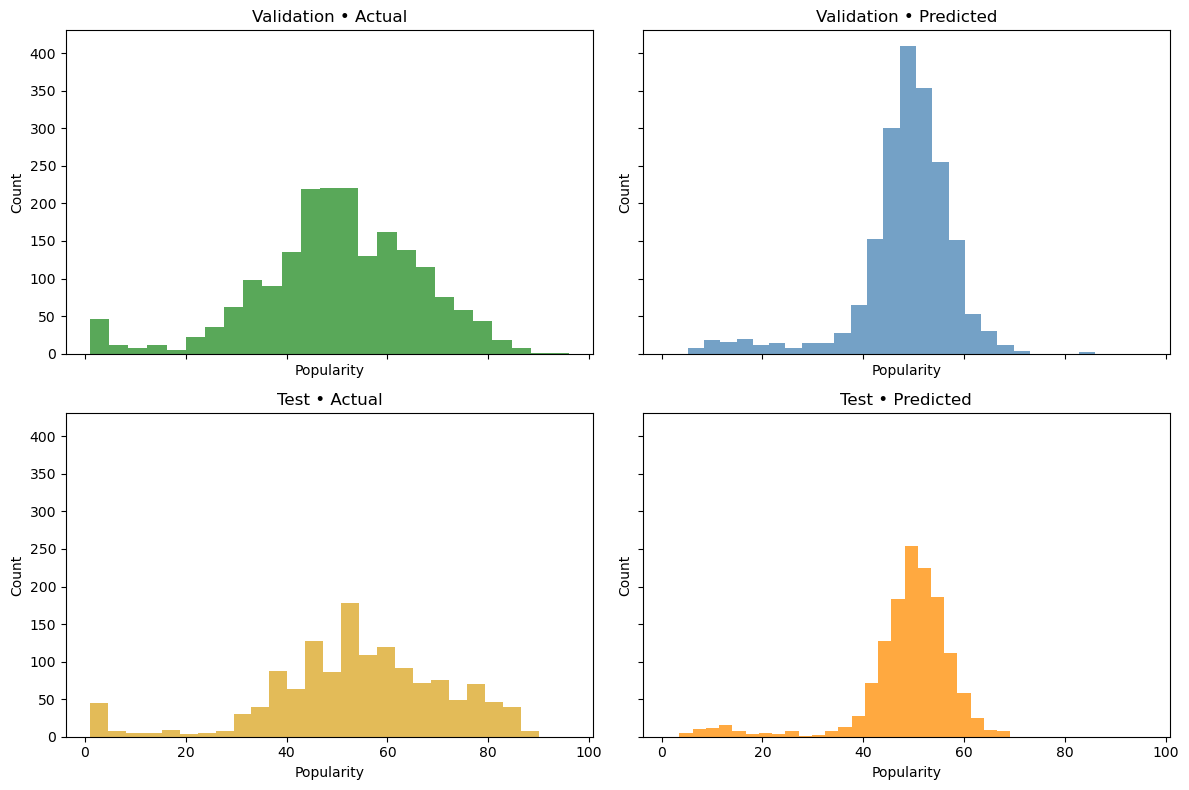


Summary statistics
Val Actual         | mean  50.00  std  16.12  min   1.00  max  96.00
Val Predicted      | mean  48.50  std   9.73  min   5.16  max  86.00
Test Actual        | mean  53.96  std  17.73  min   1.00  max  90.00
Test Predicted     | mean  48.61  std   9.92  min   3.55  max  69.17


In [15]:
import numpy as np
import matplotlib.pyplot as plt

# ───── get / recompute predictions ─────────────────────────────
#val_pred  = full_model.predict(X_val)
#test_pred = full_model.predict(X_test)

# ───── actual targets (already defined) ───────────────────────
val_true  = y_val.values if hasattr(y_val, "values") else y_val
test_true = y_test.values if hasattr(y_test, "values") else y_test

# ───── plot 2×2 histograms ────────────────────────────────────
fig, axes = plt.subplots(2, 2, figsize=(12, 8), sharex=True, sharey=True)
bins = 25

axes[0, 0].hist(val_true,  bins=bins, alpha=0.75, color="forestgreen")
axes[0, 0].set_title("Validation • Actual")

axes[0, 1].hist(val_pred, bins=bins, alpha=0.75, color="steelblue")
axes[0, 1].set_title("Validation • Predicted")

axes[1, 0].hist(test_true,  bins=bins, alpha=0.75, color="goldenrod")
axes[1, 0].set_title("Test • Actual")

axes[1, 1].hist(test_pred, bins=bins, alpha=0.75, color="darkorange")
axes[1, 1].set_title("Test • Predicted")

for ax in axes.flat:
    ax.set_xlabel("Popularity"); ax.set_ylabel("Count")

plt.tight_layout()
plt.show()

# ───── descriptive statistics ─────────────────────────────────
def describe(arr, label):
    print(f"{label:18s} | mean {np.mean(arr):6.2f}  std {np.std(arr):6.2f}  "
          f"min {np.min(arr):6.2f}  max {np.max(arr):6.2f}")

print("\nSummary statistics")
describe(val_true,  "Val Actual")
describe(val_pred,  "Val Predicted")
describe(test_true, "Test Actual")
describe(test_pred, "Test Predicted")


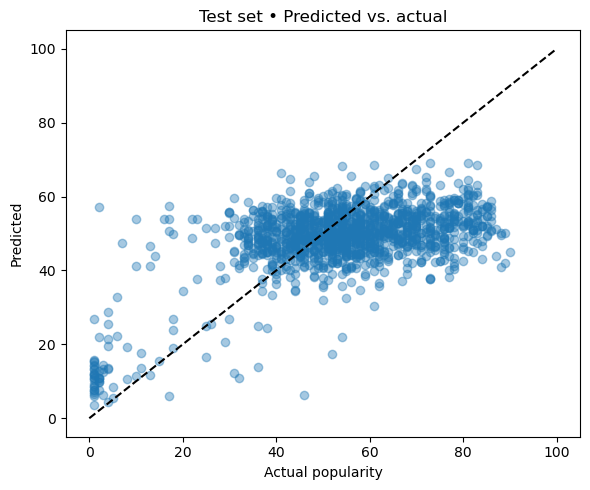

In [16]:

plt.figure(figsize=(6,5))
plt.scatter(test_true, test_pred, alpha=0.4)
plt.plot([0,100], [0,100], "k--")               # 45° reference
plt.xlabel("Actual popularity"); plt.ylabel("Predicted")
plt.title("Test set • Predicted vs. actual")
plt.tight_layout()
plt.show()

In [17]:
# ------------  DNN CELL  -----------------------------------------------
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# 1)  LOAD PREPARED DATA  (dense NumPy arrays)
data = np.load("prepared_data2/sets_notext.npz")
X_train = data["X_train"]; y_train = data["y_train"]
X_val   = data["X_val"];   y_val   = data["y_val"]
X_test  = data["X_test"];  y_test  = data["y_test"]

print(f"Loaded shapes  •  Train {X_train.shape}  Val {X_val.shape}  Test {X_test.shape}")

# 2)  BUILD MLP
n_features = X_train.shape[1]
inp = keras.Input(shape=(n_features,))

x   = layers.Dense(256, activation="relu")(inp)
x   = layers.BatchNormalization()(x)
x   = layers.Dropout(0.2)(x)
x   = layers.Dense(128, activation="relu")(inp)
x   = layers.BatchNormalization()(x)
x   = layers.Dropout(0.2)(x)
x   = layers.Dense(64, activation="relu")(x)
x   = layers.BatchNormalization()(x)
out = layers.Dense(1)(x)

model = keras.Model(inp, out)
model.compile(optimizer=keras.optimizers.Adam(1e-3),
              loss="mae",
              metrics=[keras.metrics.RootMeanSquaredError(name="rmse")])
model.summary(line_length=110)

# 3)  TRAIN
early   = keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True)
lr_sched = keras.callbacks.ReduceLROnPlateau(patience=4, factor=0.5, min_lr=1e-5)

history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=400,
    batch_size=128,
    callbacks=[early, lr_sched],
    verbose=1
)

# 4)  EVALUATE
rmse = lambda yt, yp: np.sqrt(mean_squared_error(yt, yp))
val_pred  = model.predict(X_val,  verbose=0).ravel()
test_pred = model.predict(X_test, verbose=0).ravel()

print("\n=== Validation (2019) ===")
print(f"MAE  : {mean_absolute_error(y_val,  val_pred):.2f}")
print(f"RMSE : {rmse(y_val,  val_pred):.2f}")
print(f"R²   : {r2_score(y_val,  val_pred):.3f}")

print("\n=== Test (2020) ===")
print(f"MAE  : {mean_absolute_error(y_test, test_pred):.2f}")
print(f"RMSE : {rmse(y_test, test_pred):.2f}")
print(f"R²   : {r2_score(y_test, test_pred):.3f}")


Loaded shapes  •  Train (4299, 31)  Val (1935, 31)  Test (1378, 31)


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                                   ┃ Output Shape                        ┃             Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)                       │ (None, 31)                          │                   0 │
├────────────────────────────────────────────────┼─────────────────────────────────────┼─────────────────────┤
│ dense_1 (Dense)                                │ (None, 128)                         │               4,096 │
├────────────────────────────────────────────────┼─────────────────────────────────────┼─────────────────────┤
│ batch_normalization_1 (BatchNormalization)     │ (None, 128)                         │                 512 │
├────────────────────────────────────────────────┼─────────────────────────────────────┼─────────────────────┤
│ dropout_1 (Dropout)                            │ (None, 128)                         │                   0 │
├────────────────────────────────────────────────┼─────────────────────────────────────┼─────────────────────┤
│ dense_2 (Dense)                                │ (None, 64)                          │               8,256 │
├────────────────────────────────────────────────┼─────────────────────────────────────┼─────────────────────┤
│ batch_normalization_2 (BatchNormalization)     │ (None, 64)                          │                 256 │
├────────────────────────────────────────────────┼─────────────────────────────────────┼─────────────────────┤
│ dense_3 (Dense)                                │ (None, 1)                           │                  65 │
└────────────────────────────────────────────────┴─────────────────────────────────────┴─────────────────────┘

 Total params: 13,185 (51.50 KB)

 Trainable params: 12,801 (50.00 KB)

 Non-trainable params: 384 (1.50 KB)

Epoch 1/400
34/34 ━━━━━━━━━━━━━━━━━━━━ 3s 17ms/step - loss: 49.0086 - rmse: 52.9233 - val_loss: 49.2173 - val_rmse: 51.7511 - learning_rate: 0.0010
Epoch 2/400
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 48.6232 - rmse: 52.3012 - val_loss: 48.1386 - val_rmse: 50.6965 - learning_rate: 0.0010
Epoch 3/400
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 47.8749 - rmse: 51.5622 - val_loss: 46.7601 - val_rmse: 49.3540 - learning_rate: 0.0010
Epoch 4/400
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 46.9397 - rmse: 50.6523 - val_loss: 44.7675 - val_rmse: 47.3933 - learning_rate: 0.0010
Epoch 5/400
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 45.2558 - rmse: 49.0664 - val_loss: 42.5053 - val_rmse: 45.2377 - learning_rate: 0.0010
Epoch 6/400
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 43.4276 - rmse: 47.2872 - val_loss: 40.4486 - val_rmse: 43.1809 - learning_rate: 0.0010
Epoch 7/400
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 40.9721 - rmse: 45.0855 - val_loss: 37.2519 - val_rmse: 40

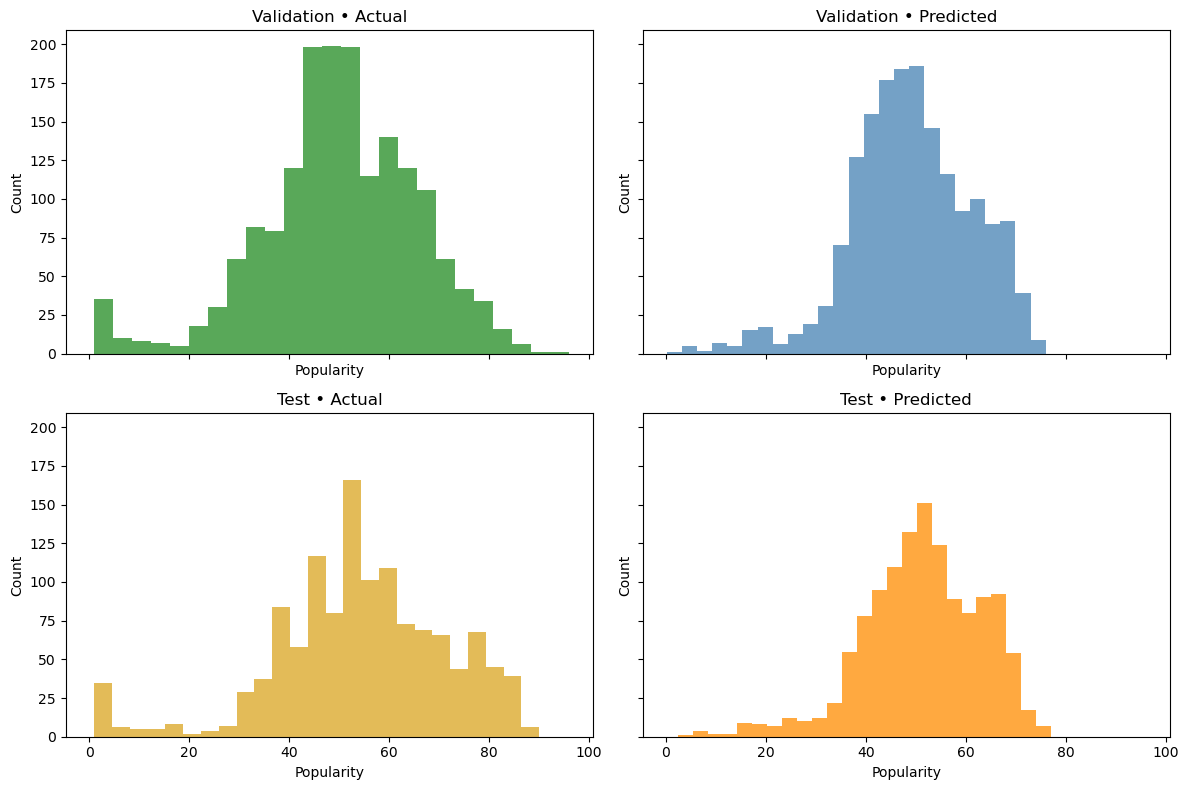


Summary statistics
Val Actual         | mean  49.90  std  15.71  min   1.00  max  96.00
Val Predicted      | mean  49.13  std  12.10  min   0.15  max  75.97
Test Actual        | mean  54.25  std  17.45  min   1.00  max  90.00
Test Predicted     | mean  51.27  std  11.87  min   2.37  max  77.05


In [ ]:
import numpy as np
import matplotlib.pyplot as plt


# ───── actual targets (already defined) ───────────────────────
val_true  = y_val.values if hasattr(y_val, "values") else y_val
test_true = y_test.values if hasattr(y_test, "values") else y_test

# ───── plot 2×2 histograms ────────────────────────────────────
fig, axes = plt.subplots(2, 2, figsize=(12, 8), sharex=True, sharey=True)
bins = 25

axes[0, 0].hist(val_true,  bins=bins, alpha=0.75, color="forestgreen")
axes[0, 0].set_title("Validation • Actual")

axes[0, 1].hist(val_pred, bins=bins, alpha=0.75, color="steelblue")
axes[0, 1].set_title("Validation • Predicted")

axes[1, 0].hist(test_true,  bins=bins, alpha=0.75, color="goldenrod")
axes[1, 0].set_title("Test • Actual")

axes[1, 1].hist(test_pred, bins=bins, alpha=0.75, color="darkorange")
axes[1, 1].set_title("Test • Predicted")

for ax in axes.flat:
    ax.set_xlabel("Popularity"); ax.set_ylabel("Count")

plt.tight_layout()
plt.show()

# ───── descriptive statistics ─────────────────────────────────
def describe(arr, label):
    print(f"{label:18s} | mean {np.mean(arr):6.2f}  std {np.std(arr):6.2f}  "
          f"min {np.min(arr):6.2f}  max {np.max(arr):6.2f}")

print("\nSummary statistics")
describe(val_true,  "Val Actual")
describe(val_pred,  "Val Predicted")
describe(test_true, "Test Actual")
describe(test_pred, "Test Predicted")


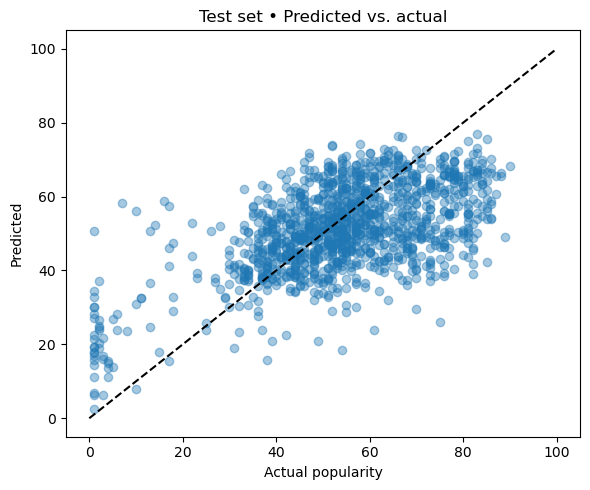

In [ ]:

plt.figure(figsize=(6,5))
plt.scatter(test_true, test_pred, alpha=0.4)
plt.plot([0,100], [0,100], "k--")            
plt.xlabel("Actual popularity"); plt.ylabel("Predicted")
plt.title("Test set • Predicted vs. actual")
plt.tight_layout()
plt.show()